## Importing necessary libraries

In [1]:
#!pip install tensorflow_addons

In [33]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle
import nltk.translate.gleu_score as gleu
import shutil
from IPython.display import Image
import io
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from nltk.translate.gleu_score import sentence_gleu

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# !wget --header="Host: doc-0c-2g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_p1fg4b07u3raciih5atnsbt7sdk7uaqn=04473764286494136551|1619699175000|00bm91m6ufdprhohdrubi69eqchdldtp" --header="Connection: keep-alive" "https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/k57aefr9gh8rpf3r9srcg2pseasqmf46/69phnf39b8iqpda67kot4675v9c0lan4/1619699175000/04473764286494136551/04473764286494136551/1ga0tuabgtHjzsctSeAOY3D7TduaWLtGL?e=download&authuser=0" -c -O '7.zip'
# !unzip '7.zip'

## Making data model ready

In [5]:
## loading train, test and CV data
train = pd.read_csv("train_new.csv")
cv = pd.read_csv("cv_new.csv")
test = pd.read_csv("test_new.csv")

In [6]:
# code reference https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
# loading saved tokenizer
with open("tokenizer_incorr_new.pickle","rb") as temp1:
    tokenizer_incorr = pickle.load(temp1)
    
with open("tokenizer_corr_inp_new.pickle","rb") as temp2:
    tokenizer_corr_inp = pickle.load(temp2)
    
with open("tokenizer_corr_out_new.pickle","rb") as temp3:
    tokenizer_corr_out = pickle.load(temp3)

Tokenizing senetence for feeding to encoder

In [7]:
# tokenizer_incorr = Tokenizer(filters="",lower=False)
# tokenizer_incorr.fit_on_texts(train["incorrect"].values)
incorr_train = np.array(tokenizer_incorr.texts_to_sequences(train["incorrect"].values))
incorr_cv = np.array(tokenizer_incorr.texts_to_sequences(cv["incorrect"].values))
print("vocab size of incorrrect sentences is",len(tokenizer_incorr.word_index))

vocab size of incorrrect sentences is 52593


Tokenizing senetence for feeding to decoder as inpput

In [8]:
# tokenizer_corr_inp = Tokenizer(filters="",lower=False)
# tokenizer_corr_inp.fit_on_texts(train["correct_inp"].values)
corr_train_inp = np.array(tokenizer_corr_inp.texts_to_sequences(train["correct_inp"].values))
corr_cv_inp = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_inp"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_inp.word_index))

vocab size of corrrect sentences is 47110


Tokenizing senetence which will be output of decoder

In [9]:
# tokenizer_corr_out = Tokenizer(filters="",lower=False)
# tokenizer_corr_out.fit_on_texts(train["correct_out"].values)
corr_train_out = np.array(tokenizer_corr_out.texts_to_sequences(train["correct_out"].values))
corr_cv_out = np.array(tokenizer_corr_out.texts_to_sequences(cv["correct_out"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_out.word_index))

vocab size of corrrect sentences is 47110


In [10]:
## #save keras tokenizer

# with open("tokenizer_incorr_new.pickle","wb") as temp1:
#     pickle.dump(tokenizer_incorr,temp1)
    
# with open("tokenizer_corr_inp_new.pickle","wb") as temp2:
#     pickle.dump(tokenizer_corr_inp,temp2)
    
# with open("tokenizer_corr_out_new.pickle","wb") as temp3:
#     pickle.dump(tokenizer_corr_out,temp3)

Padding training data

In [11]:
incorr_train = np.array(pad_sequences(incorr_train,maxlen=25,padding="post",truncating='post'))
corr_train_inp = np.array(pad_sequences(corr_train_inp,maxlen=25,padding="post",truncating='post'))
corr_train_out = np.array(pad_sequences(corr_train_out,maxlen=25,padding="post",truncating='post'))

incorr_cv = np.array(pad_sequences(incorr_cv,maxlen=25,padding="post",truncating='post'))
corr_cv_inp = np.array(pad_sequences(corr_cv_inp,maxlen=25,padding="post",truncating='post'))
corr_cv_out = np.array(pad_sequences(corr_cv_out,maxlen=25,padding="post",truncating='post'))

#### Using pretrained fasttext embeddings

In [12]:
# !wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://fasttext.cc/" --header="Cookie: __cfduid=d0995b9a675be50a9c5a78dbf19cacc201617113683" --header="Connection: keep-alive" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'
# !unzip "wiki-news-300d-1M.vec.zip"

In [13]:
##code taken from https://fasttext.cc/docs/en/crawl-vectors.html

# def load_vectors(fname):
#     """
#     this function tales name of zipped file as input and returns word and corresponging embeddings as dictionary
#     """
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data
# dic = load_vectors("wiki-news-300d-1M.vec")

In [14]:
##save dictionary to disk
# with open("dic_atention.pickle","wb") as temp1:
#     pickle.dump(dic,temp1)

In [15]:
# with open("dic_atention.pickle","rb") as temp1:
#     embeddings_index = pickle.load(temp1)

In [16]:
# prepare embedding matrix 1

# embedding_matrix1 = np.zeros((52594, 300))
# for word, i in tokenizer_incorr.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix1[i] = list(embedding_vector)
#     else:
#         print("hi")

# # save embedding matrix 1 to disk
# np.save("incorr_matrix_new",embedding_matrix1)

In [17]:
embedding_matrix1 = np.load("incorr_matrix_new.npy")
#embedding_matrix1.shape

In [18]:
# prepare embedding matrix 2

# embedding_matrix2 = np.zeros((47111, 300))
# for word, i in tokenizer_corr_inp.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix2[i] = list(embedding_vector)
#     else:
#         print(word,i)
        
# ## save embedding matrix 2 to disk
# np.save("corr_matrix_new",embedding_matrix2)

In [19]:
embedding_matrix2 = np.load("corr_matrix_new.npy")
#embedding_matrix2.shape

#### Defining model artchitecture

In [20]:
# code taken from attention mechanism assignment

############################## Encoder class #############################################################

class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=300, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder", weights=[embedding_matrix1], trainable=False)
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence,states):

        output1 = self.embedding(input_sequence)
        mask = self.embedding.compute_mask(input_sequence)
        enco_output, enco_state_h, enco_state_c = self.encoder_lstm(output1, initial_state=states,mask=mask)
        return enco_output, enco_state_h, enco_state_c

    
    def initialize_states(self,batch_size):

        initial_hidden_state = tf.zeros([batch_size,self.lstm_size])
        initial_cell_state = tf.zeros([batch_size,self.lstm_size])
        
        return [initial_hidden_state,initial_cell_state]
    
############################## Decoder class #############################################################
    
# code reference for concat scoing scoring function from https://www.tensorflow.org/tutorials/text/nmt_with_attention
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function,att_units):


    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()
    self.scoring_function = scoring_function
    
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
        #self.similarity = []
        self.softmax = Softmax(axis=1)
        #self.similarity = [j for j in range(att_units)]
        pass
  
  def call(self,decoder_hidden_state,encoder_output):
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        #print(decoder_hidden_state.shape,encoder_output.shape)
        attention_weight = tf.matmul(encoder_output,tf.expand_dims(decoder_hidden_state,axis=2))
        #print(attention_weight.shape)
        context = tf.matmul(tf.transpose(encoder_output, perm=[0,2,1]),attention_weight)
        context = tf.squeeze(context,axis=2)
        output = self.softmax(attention_weight)
        return context,output
    
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__()
        self.tar_vocab_size = tar_vocab_size
        self.lstm_size = dec_units
        self.att_units = att_units
        self.score_fun = score_fun
        #print("output vocan size ",tar_vocab_size)
        self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=300, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder",weights=[embedding_matrix2], trainable=False)
        self.lstmcell = tf.keras.layers.LSTMCell(dec_units)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)
        self.dense   = Dense(tar_vocab_size)
        #self.decoder_lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="decoder_LSTM")
        self.attention=Attention(self.score_fun,self.att_units)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):

        output2 = self.embedding(input_to_decoder)
        mask = self.embedding.compute_mask(input_to_decoder)
        #print("one step decoder SHAPE after embedding:",output2.shape)
        output2 = tf.squeeze(output2,axis=1)
        #print("one step decoder SHAPE after embedding and sqeezing:",output2.shape)

        # step b
#         attention=Attention(self.score_fun,self.att_units)
        context_vector,attention_weights=self.attention(state_h,encoder_output)
        # step c
        output3 = tf.concat([context_vector,output2],1)
        #print("shape after concating ",output3.shape)
        output3 = tf.expand_dims(output3,1)
        deco_output, deco_state_h, deco_state_c = self.decoder_lstm(output3,initial_state=[state_h,state_c],mask=mask)
        # step e
        output4 = self.dense(deco_output)
        output4 = tf.squeeze(output4,axis=1)
        #print("shape afyer dense layer and softmax ",output4.shape)
        return output4,deco_state_h, deco_state_c,attention_weights,context_vector
    
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.input_length = input_length
        self.score_fun = score_fun
        self.onestepdecoder = One_Step_Decoder(self.out_vocab_size,self.embedding_dim,self.input_length,self.dec_units,self.score_fun,self.att_units)
        
    @tf.function    
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):


        all_outputs = tf.TensorArray(tf.float32,size=input_to_decoder.shape[1])
        for timestep in range(input_to_decoder.shape[1]):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs = all_outputs.write(timestep,output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        #print("all outpt shape is ",all_outputs.shape)
        return all_outputs
    
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,out_vocab_size,embedding_size,lstm_size,input_length,batch_size,score_fun,att_units,*args):
    #Intialize objects from encoder decoder
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #print("input vocab size in encoder decoder class",inp_vocab_size)
    self.encoder = Encoder(inp_vocab_size,embedding_size,lstm_size,input_length)
    #print("output vocab size in encoder decoder class",out_vocab_size)
    self.decoder = Decoder(out_vocab_size,embedding_size,input_length,lstm_size,score_fun,att_units)
    #self.dense   = Dense(out_vocab_size, activation='softmax')
    #self.flatten = Flatten()
    self.batch = batch_size
  
  def call(self,data):
    input,output = data[0], data[1]
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    l = self.encoder.initialize_states(self.batch)
    #print("WE ARE INITIALIZING encoder WITH initial STATES as zeroes :",l[0].shape, l[1].shape)
    encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input,l)
    decoder_output = self.decoder(output,encoder_output,encoder_final_state_h,encoder_final_state_c)
    return decoder_output

In [21]:
inp_vocab_size = 52594
out_vocab_size = 47111
embedding_dim=300
input_length=25
lstm_size=128
batch_size=512
score_fun = "dot"
att_units = 128
#model = encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size,score_fun,att_units)

#optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.1)

#defining custom loss function which will not consider loss for padded zeroes
# code taken from attention assignment
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
#model.compile(optimizer=optimizer,loss=loss_function)

In [22]:
## code taken from https://github.com/bckenstler/CLR
class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())    
            
        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def on_epoch_begin(self, epoch, logs=None):
        print(" learning rate for epoch",epoch,"is",self.model.optimizer.lr.numpy())

In [19]:
##Load the TensorBoard notebook extension
import datetime
%load_ext tensorboard
!rm -rf ./logs/

Train the model

In [20]:
filepath="/content/drive/MyDrive/attention_model/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto',save_weights_only=True)

log_dir = "/content/drive/MyDrive/attention_model/logs/fit5/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

customlr = CyclicLR()

model.fit(x=[incorr_train,corr_train_inp],y=corr_train_out, epochs=12,batch_size=512,validation_data=([incorr_cv,corr_cv_inp],corr_cv_out),callbacks=[model_checkpoint,tensorboard_callback,customlr])

Epoch 1/12
 learning rate for epoch 0 is 0.001
724/724 [==============================] - 371s 477ms/step - loss: 4.3742 - val_loss: 3.6523

Epoch 00001: val_loss improved from inf to 3.65229, saving model to /content/drive/MyDrive/attention_model/weights-01-3.6523.hdf5
Epoch 2/12
 learning rate for epoch 1 is 0.00281
724/724 [==============================] - 344s 475ms/step - loss: 3.5633 - val_loss: 3.3460

Epoch 00002: val_loss improved from 3.65229 to 3.34595, saving model to /content/drive/MyDrive/attention_model/weights-02-3.3460.hdf5
Epoch 3/12
 learning rate for epoch 2 is 0.00462
724/724 [==============================] - 344s 476ms/step - loss: 3.3276 - val_loss: 3.2681

Epoch 00003: val_loss improved from 3.34595 to 3.26806, saving model to /content/drive/MyDrive/attention_model/weights-03-3.2681.hdf5
Epoch 4/12
 learning rate for epoch 3 is 0.00557
724/724 [==============================] - 344s 475ms/step - loss: 3.2914 - val_loss: 3.3394

Epoch 00004: val_loss did not im

In [27]:
#%tensorboard --logdir /content/drive/MyDrive/attention_model/logs/fit5

#### load the trained model

In [23]:
model = encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size,score_fun,att_units)
model.compile(optimizer=optimizer,loss=loss_function)
model.train_on_batch([incorr_train[:512],corr_train_inp[:512]],corr_train_out[:512])
# load weights after third epoch as it has least validation loss
model.load_weights('weights-03-3.2681.hdf5')

Defining predict function

In [29]:
corr_dict = tokenizer_corr_out.word_index
inv_corr = {v: k for k, v in corr_dict.items()}

def predict(input_sentence):
    """
    this function takes incorrect sentence as input and returns correct sentence as output
    """
    input_sentence = tokenizer_incorr.texts_to_sequences([input_sentence])[0]
    #print(input_sentence)
    #x = len(input_sentence)
    #attention_plot = np.zeros((22,22))# here 22,22 is length of italian and english sentences
    initial_hidden_state = tf.zeros([1,128])
    initial_cell_state = tf.zeros([1,128])
    encoder_initial_state = [initial_hidden_state,initial_cell_state]
    input_sentence = tf.keras.preprocessing.sequence.pad_sequences([input_sentence],maxlen=25,padding='post')
    input_sentence = input_sentence[0]
    enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_sentence,0),encoder_initial_state)
    #states_values = [enc_state_h, enc_state_c]
    pred = []
    sentence = []
    cur_vec = np.ones((1, 1),dtype='int')
    for i in range(26):
        #print(i)
        #print(enc_output.shape)
        infe_output,deco_state_h, deco_state_c,attention_weights,context_vector = model.layers[1].onestepdecoder(cur_vec, enc_output,enc_state_h, enc_state_c)
        enc_state_h, enc_state_c = deco_state_h, deco_state_c
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        #print(cur_vec)
        if inv_corr[cur_vec[0][0]] == '@':
            break
        pred.append(cur_vec[0][0])
    for i in pred:
        sentence.append(inv_corr[i])
    return " ".join(sentence)

#### GLUE Score on test data¶

In [34]:
gleu_score_test = 0
length = 1000

for i in range(length):
    reference = [test["correct"].values[i:i+1][0].split()]
    candidate = predict(test["incorrect"].values[i:i+1][0]).split()
    gleu_score_test = gleu_score_test + sentence_gleu(reference, candidate)
    #bleu_score_test = bleu_score_test + sentence_bleu(reference, candidate)
    #print(gleu_score,bleu_score)
print("Final GLEU Score on Test data are",gleu_score_test/length)

Final GLEU Score on Test data are 0.0


#### Plotting tensorboard plots

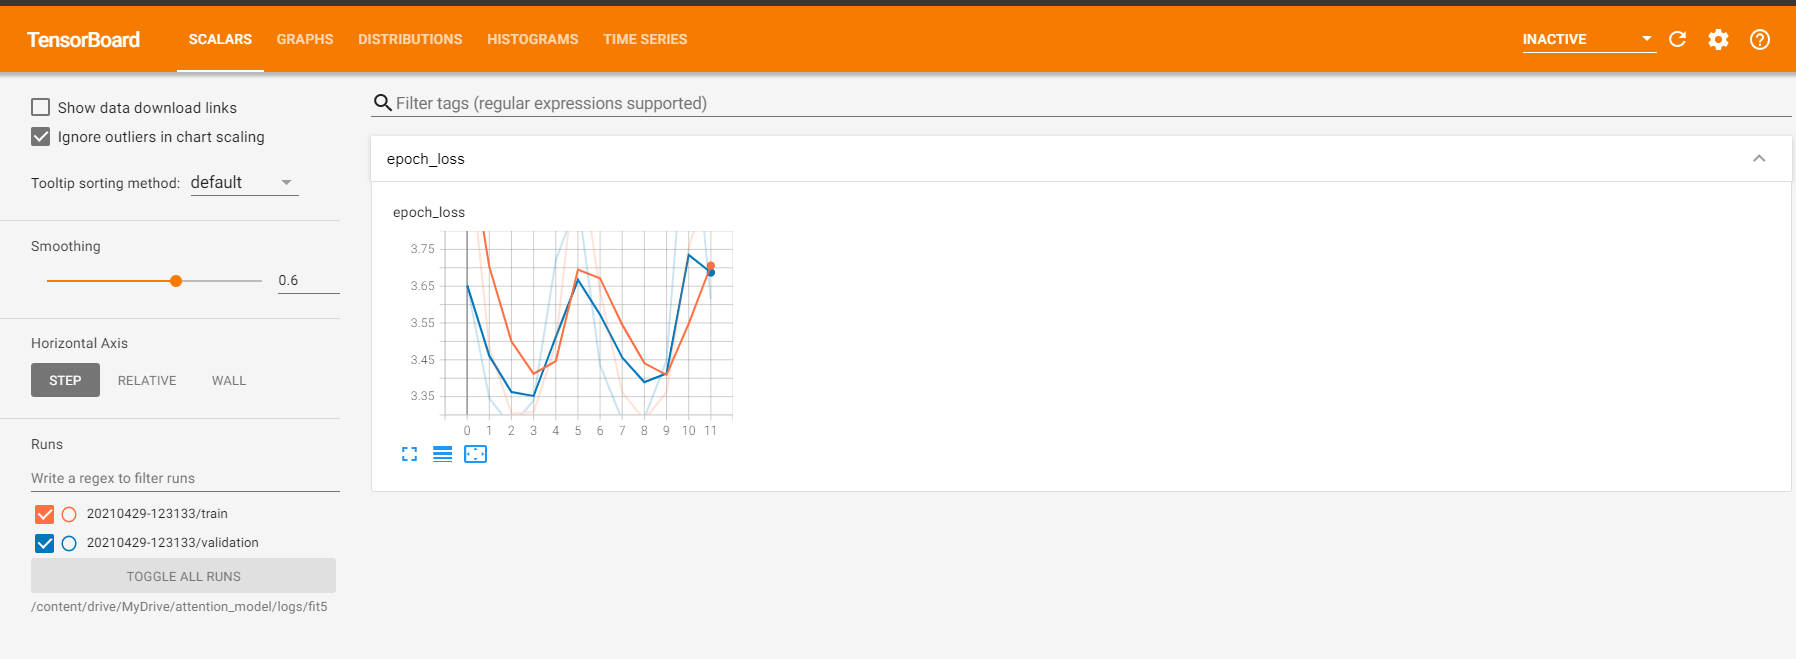

In [25]:
Image(filename='Screenshot (317).png')

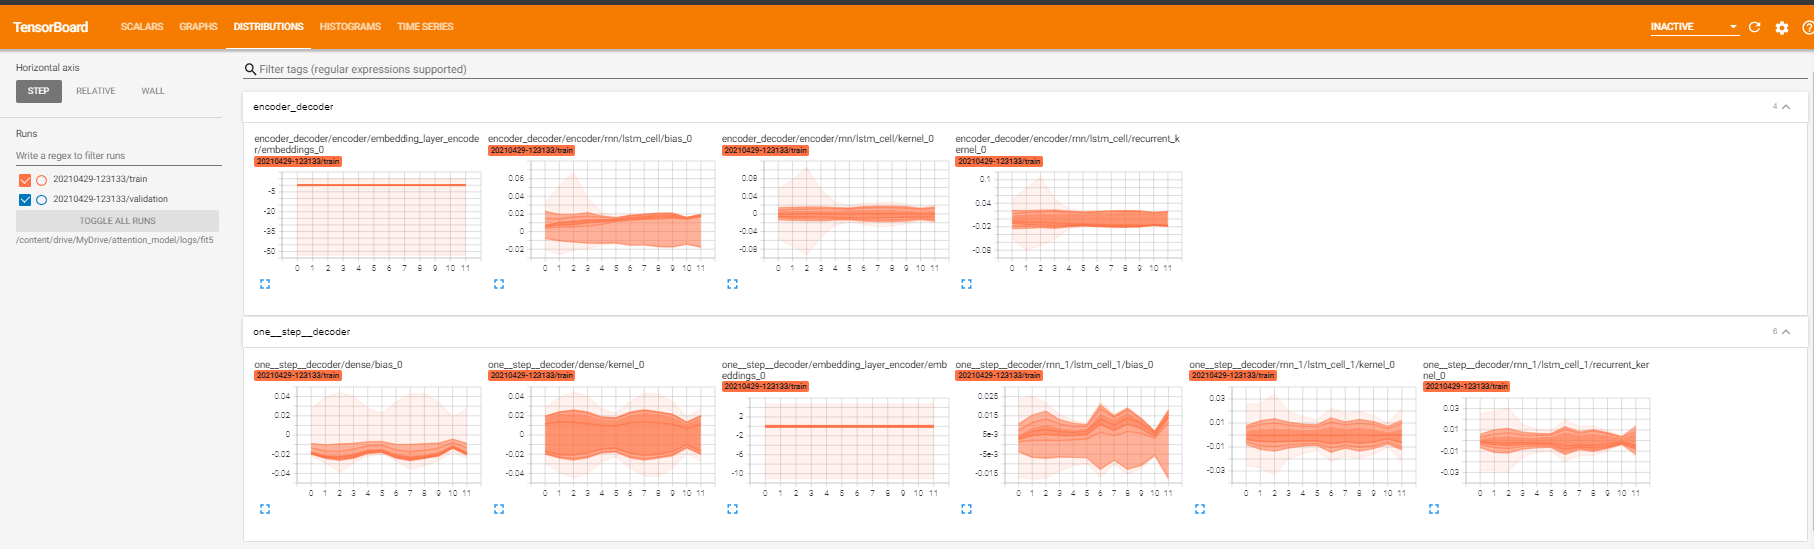

In [26]:
Image(filename='Screenshot (318).png')

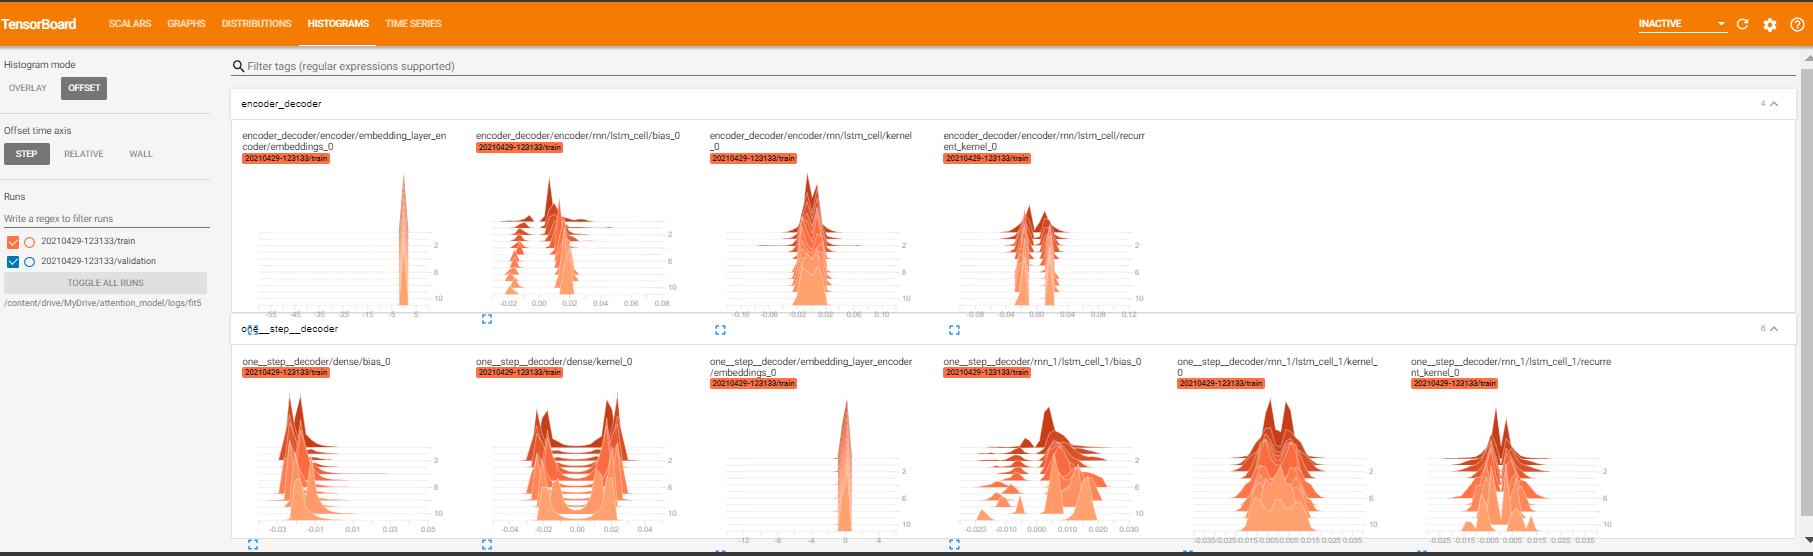

In [27]:
Image(filename='Screenshot (319).png')